# Firing-rate model of decision-making and working memory

Consider a population rate model of a recurrent neural circuit, described in [Wang (2002)](https://web.stanford.edu/group/brainsinsilicon/documents/Wang_2002.pdf) and [Wong and Wang (2006)](https://www.jneurosci.org/content/26/4/1314). The model has two excitatory neural assemblies, that compete with each other through a shared pool of inhibitory neurons. Let $r_1$ and $r_2$ be their respective population-firing rates, and the total synaptic input current $I_i$ and the resulting firing rate $r_i$ of the neural population $i$ obey the following input-output relationship ($F−I$ curve):

\begin{equation}
r_i = F(I_i) = \frac{aI_i − b}{1 − e^{(−d(aI_i − b))}}
\end{equation}

which captures the current-frequency function of a leaky integrate-and-fire neuron. Assume that the ‘synaptic drive variables’ $s_1$ and $s_2$ obey:

\begin{equation}
\frac{ds_1}{dt} = \phi F(I)\gamma(1 − s_1) − \frac{s_1}{\tau_s}
\end{equation}

\begin{equation}
\frac{ds_2}{dt} = \phi F(I)\gamma(1 − s_2) − \frac{s_2}{\tau_s}
\end{equation}

where $I_2 = g_Es s_1 - g_I s_2 + I_b + g_{ext} \mu_1$ and $I_2 = g_Es s_2 - g_I s_1 + I_b + g_{ext} \mu_2$ and $I_{ext} = I_0 + I_1(t)$. The synaptic time constant $\tau_s$ = 100 ms for slow, NMDA receptor dependent synaptic excitation. Stimulus-selective inputs to populations 1 and 2 are governed by unitless parameters $\mu_1$ and $\mu_2$, respectively. $I_b$ is the background input which has a mean ($I_0$) and a noise component described by an Ornstein-Uhlenbeck process:

\begin{equation}
\tau_0 \frac{dI_{b1}}{dt} = -\frac{I_{b1}-I_0}{\tau_0} + \eta_1(t) \sqrt{\tau_0 \sigma^2}
\end{equation}

\begin{equation}
\tau_0 \frac{dI_{b2}}{dt} = -\frac{I_{b2}-I_0}{\tau_0} + \eta_2(t) \sqrt{\tau_0 \sigma^2}
\end{equation}

where $\eta_2(t)$ is a Gaussian white-noise with zero mean and unit standard deviation.

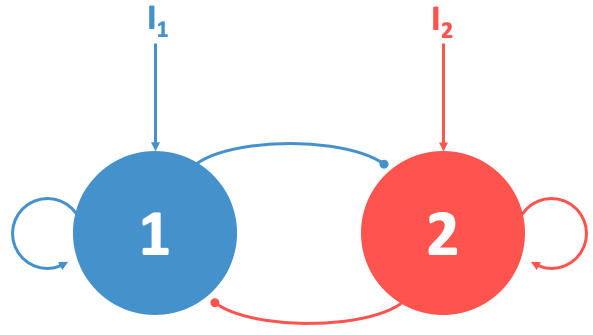

In [554]:
# Import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint

# Define firing-rate model object

In [669]:
class firing_rate_network:
    # parameter initialization
    def __init__(self, a=270., b=108., d=.154, gamma=.64, tau_s=.1, tau0=.002,
                 g_E=.2609, g_I=-.0497, I_o=.3255, g_ext=.00052):
        self.a = a              # in Hz/nA
        self.b = b              # Hz
        self.d = d              # synaptic time constant in s
        self.gamma = gamma      # saturation factor for gating variable
        self.tau_s = tau_s      # in s
        self.tau0 = tau0        # in s
        self.g_E = g_E          # excitatory strength in nA
        self.g_I = g_I          # cross-inhibition strength in nA
        self.I_o = I_o          # background current in nA
        self.g_ext = g_ext      # stimulus input strength [nA/Hz]
        
    # compute network firing rate
    def rate(self, I):
        return (self.a*I - self.b) / (1. - np.exp(-self.d*(self.a*I - self.b)))
    
    # firing rate network model simulations using Euler approximation
    def simulation(self, I_1, I_2, I_12=0, t=2, t1=.2, t12=.5, t2=.2, 
                   pulse_t1=0., pulse_t12=0., pulse_t2=0.,
                   s1=.1, s2=.1, sigma=.02, phi=1., n_trial=10):
        dt = 0.5/1000 #self.tau_s/10
        T = np.arange(0, t, dt)
        stim11 = (T>t1)  * (T<(t1+pulse_t1))   * I_1  * self.g_ext
        stim12 = (T>t12) * (T<(t12+pulse_t12)) * I_12 * self.g_ext
        stim1 = stim11 + stim12
        stim2  = (T>t2)  * (T<(t2+pulse_t2))   * I_2  * self.g_ext

        S1 = []
        S2 = []
        R1 = []
        R2 = []
        s1 = 0.1*np.ones(n_trial)
        s2 = 0.1*np.ones(n_trial)
        
        Ieta1 = np.zeros(n_trial)
        Ieta2 = np.zeros(n_trial)
        
        for t in range(len(T)):
            Isyn1 = self.g_E*s1 + self.g_I*s2 + stim1[t] + Ieta1
            Isyn2 = self.g_E*s2 + self.g_I*s1 + stim2[t] + Ieta2
            
            r1 = self.rate(Isyn1)
            r2 = self.rate(Isyn2)
            
            s1_next = s1 + phi*(r1*self.gamma*(1 - s1) - (s1/self.tau_s))*dt
            s2_next = s2 + phi*(r2*self.gamma*(1 - s2) - (s2/self.tau_s))*dt
            
            Ieta1_next = Ieta1 + (dt/self.tau0)*(self.I_o-Ieta1) + np.sqrt(dt/self.tau0)*sigma*np.random.randn(n_trial)
            Ieta2_next = Ieta2 + (dt/self.tau0)*(self.I_o-Ieta2) + np.sqrt(dt/self.tau0)*sigma*np.random.randn(n_trial)
            
            s1 = s1_next
            s2 = s2_next
            Ieta1 = Ieta1_next
            Ieta2 = Ieta2_next

            S1.append(s1)
            S2.append(s2)
            R1.append(r1)
            R2.append(r2)
        return S1, S2, R1, R2, stim1, stim2, T

In [670]:
def plot_NetworkAct_Input(T, I1, I2, R1, R2):
    fig = plt.figure(figsize=(12,14))
    ax = fig.add_axes([0, 0.35, 0.35, 0.1])
    plt.plot(T, I1, 'blue', lw=2)
    plt.plot(T, I2, 'red')
    plt.ylabel('input (nA)')
    
    plt.plot([], [], 'o', c='limegreen')
    plt.plot([], [], 'o', c='purple')
    plt.legend(['neural population 1', 'neural population 2', 'init. cond.', 'final cond.'], 
               bbox_to_anchor=(3, 1))

    ax = fig.add_axes([0, 0.1, 0.35, 0.2])
    plt.plot(T, R1, 'blue', alpha=.2)
    plt.plot(T, R2, 'red' , alpha=.2)
    plt.xlabel('time (s)')
    plt.ylabel('activity (Hz)')
    
    ax = fig.add_axes([0.45, 0.3, 0.35, 0.15])
    plt.plot(T, S1, 'blue', alpha=.2)
    plt.plot(T, S2, 'red' , alpha=.2)
    plt.xlabel('time (s)')
    plt.ylabel('synaptic drive')
    
    ax = fig.add_axes([0.45, 0.1, 0.15, 0.15])
    plt.plot(S1, S2, 'k', alpha=.2)
    plt.plot(S1[0], S2[0], 'o', c='limegreen')
    plt.plot(S1[-1], S2[-1], 'o', c='purple')
    plt.xlabel('synaptic drive pop. 1')
    plt.ylabel('synaptic drive pop. 2')
    plt.xlim((0, 0.7))
    plt.ylim((0, 0.7))
    
    ax = fig.add_axes([0.65, 0.1, 0.15, 0.15])
    plt.plot(R1, R2, 'k', alpha=.2)
    plt.plot(R1[0], R2[0], 'o', c='limegreen')
    plt.plot(R1[-1], R2[-1], 'o', c='purple')
    plt.xlabel('act. pop. 1 (Hz)')
    plt.ylabel('act. pop. 2 (Hz)')
    plt.xlim((-2, 45))
    plt.ylim((-2, 45))
    plt.show()

# 1) Initiate and simulate dynamics firing-rate model
Simulate firing-rate network with parameters $a=270Hz/nA, b=108Hz, d=.154s, \gamma=.64, \tau_s=.1s, g_E=.28nA, g_I=.047nA, g_{ext}=.00052nA, I_0=.3255nA$, $\tau_0=2ms$, noise amplitude $\sigma=.02$. We set initial conditions of $s_1=s_2=.1$.

If we initiate the network and run a simulation without providing any input to any of the populations. We see that the system remains in a stable solution defined by the two populations of neurons at a low firing rate around 2Hz. We can also observe that the synaptic drive into either populations is also defined by this low activity attractor. 

In [671]:
network = firing_rate_network()

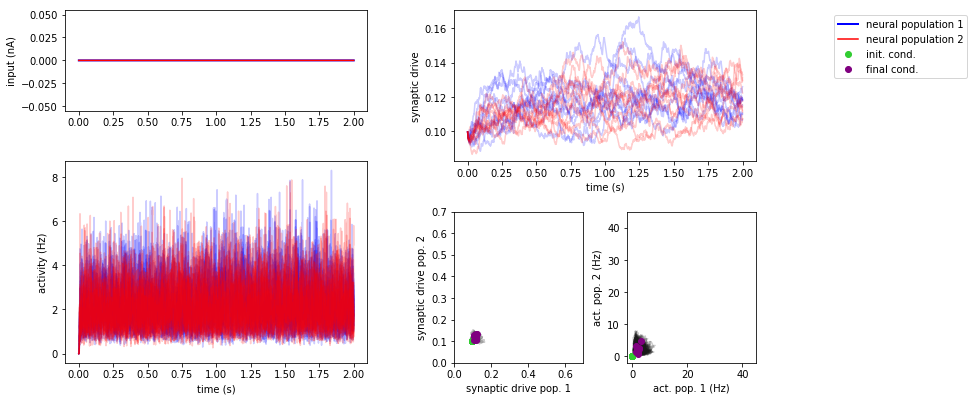

In [672]:
S1, S2, R1, R2, I1, I2, T = network.simulation(I_1=0, I_2=0)
plot_NetworkAct_Input(T, I1, I2, R1, R2)

If we provide one of the populations with a strong but fast input, we see that the stimulated population evolves towards a state of higher activity while the other population is further suppresed. 

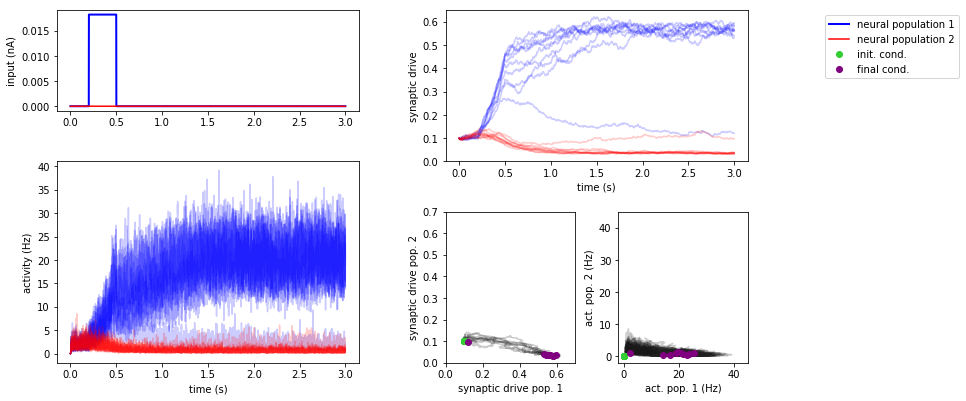

In [673]:
S1, S2, R1, R2, I1, I2, T = network.simulation(I_1=35, I_2=0, t=3, t1=.2, pulse_t1=.3, n_trial=10)
plot_NetworkAct_Input(T, I1, I2, R1, R2)

We can observe the same but inverse outcome when stimulating the other population.

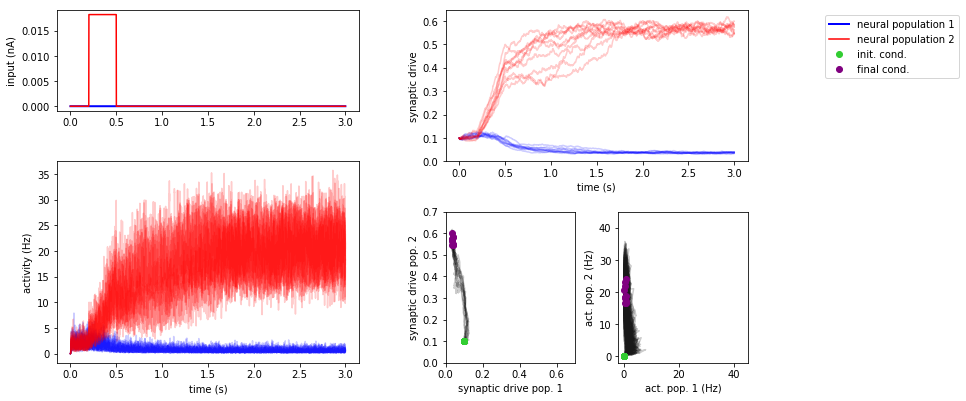

In [674]:
S1, S2, R1, R2, I1, I2, T = network.simulation(I_1=0, I_2=35, t=3, t2=.2, pulse_t2=.3, n_trial=10)
plot_NetworkAct_Input(T, I1, I2, R1, R2)

However, if we try to stimulate the two populations only one of them exhibits the high stable activity while the other is silenced. In order to drive the system to the attractor state in which the other neural population is active, the input required is much higher than when we started from the two populations at the low firing rate. This can be interpreted from the model because having a population at a high activity level drives inhibition onto the other population.

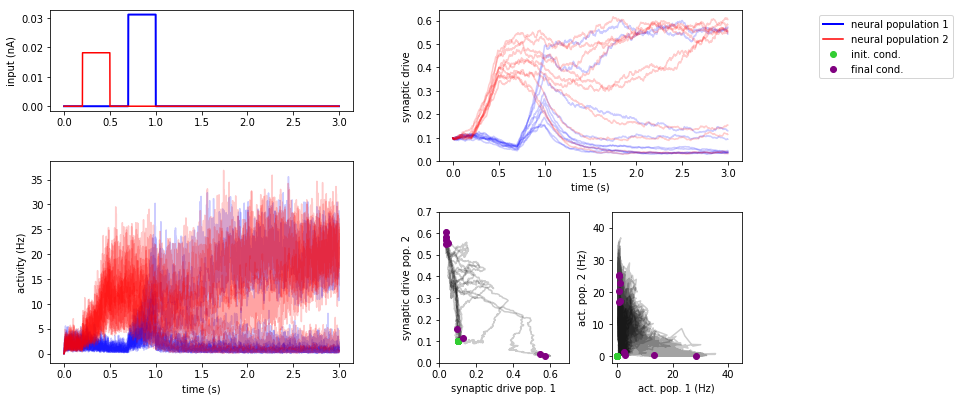

In [739]:
S1, S2, R1, R2, I1, I2, T = network.simulation(I_1=60, I_2=35, t=3, t1=.7, t2=.2, pulse_t1=.3, pulse_t2=.3, n_trial=10)
plot_NetworkAct_Input(T, I1, I2, R1, R2)

To return to the low activity attractor one needs to provide a negative input to the neural population that is at the high firing rate state.

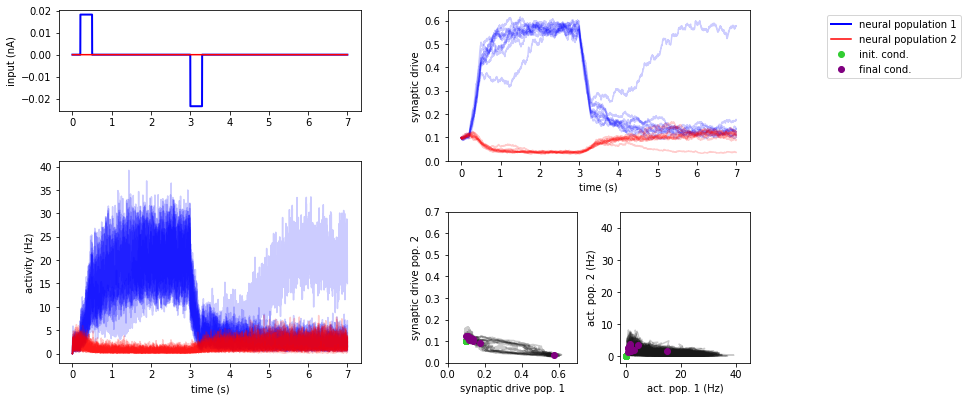

In [675]:
S1, S2, R1, R2, I1, I2, T = network.simulation(I_1=35, I_2=0, I_12= -45, t=7, t1=.2, t12=3, 
                                               pulse_t1=.3, pulse_t12=.3, n_trial=10)
plot_NetworkAct_Input(T, I1, I2, R1, R2)

# (2) Coin-tossing
This model can make binary predictions given a particular input. When the input to the two populations is the same, the network evolves to one of the two high firing rate attractors at 'chance' (determined by the noise). This can be described as a winner take all system. If we generate a large number of simulations on average 50% of the times population 1 will be in the higher firing rate state and the other 50% population 2. 

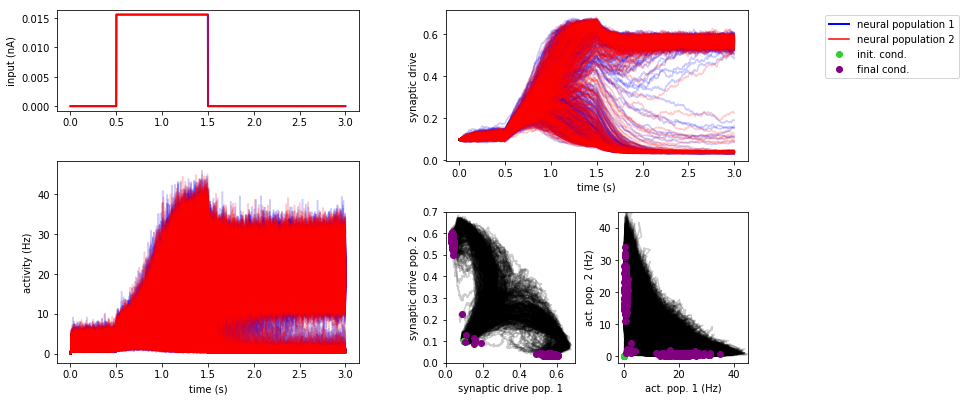

The probability of chosing population 1 is: 0.474


In [741]:
S1, S2, R1, R2, I1, I2, T = network.simulation(I_1=30, I_2=30, t=3, t1=.5, t2=.5, 
                                               pulse_t1=1., pulse_t2=1., n_trial=500)
plot_NetworkAct_Input(T, I1, I2, R1, R2)
p_C1 = sum(np.array(R1)[-1, :] > np.array(R2)[-1, :]) / len(R1[0]) 

print('The probability of chosing population 1 is: '+str(p_C1))

# (3) Cohorence level
A major factor determining which population will 'win' is the coherence between the inputs to the two populations, which can be described as $c' = (\mu_1-\mu2)/(\mu_1+\mu_2)$. As we increase the coherence the probability of choosing the first population increases from chance (.5, as we show above for $0$ coherence) to 1 when the coherence is large enough. We can define an arbitrary threshold of neural population activity to declare a winning population or choice. 

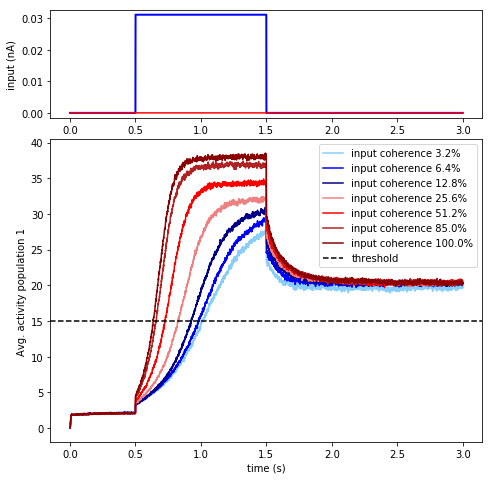

In [710]:
c = np.array([0.032, 0.064, 0.128, 0.256, 0.512, 0.85, 1.0])
# I_1 = 40 * np.ones((len(c, )))
# I_2 = I_1* (1-c)/(1+c)
mu = 30
I_1 = mu * (1 + c)
I_2 = mu * (1 - c)

RT = []
P_C1 = []
threshold = 15

cmap = ['lightskyblue', 'blue', 'darkblue', 'lightcoral', 'red', 'firebrick', 'darkred']
cnt =0

fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0, 0, 1, .7])

for ii in range(len(I_2)):
    rt = []
    _, _, R1, R2, I1, I2, T = network.simulation(I_1=I_1[ii], I_2=I_2[ii], t=3, t1=.5, t2=.5, 
                                               pulse_t1=1., pulse_t2=1., n_trial=500)
    
    p_C1 = sum(np.array(R1)[-1, :] > np.array(R2)[-1, :]) / len(R1[0]) 
    
    RT1 = T[np.argmax(np.array(R1)>threshold, axis=0)]
    RT2 = T[np.argmax(np.array(R2)>threshold, axis=0)]
    P_C1.append(p_C1)
    
    mask = []
    
    for i in range(len(RT1)):
        a = RT1[i]
        b = RT2[i]
        if a == 0 and b ==0:
            rt.append(0)
#             print('change threshold or input parameters')
        elif a ==0 and b > 0:
            rt.append(b)
        elif b ==0 and a > 0:
            rt.append(a)
            mask.append(i)
        elif b >0 and a > 0:
            if b > a:
                rt.append(a)
                mask.append(i)
            else:
                rt.append(b)
    
    plt.plot(T, np.mean((np.array(R1)[:, mask]), axis=1), c=cmap[cnt])
#     plt.plot(T, np.mean(R1, axis=1), c=cmap[cnt])
    
    cnt +=1
                
    RT.append(rt)

plt.axhline(y=threshold, color='k', linestyle='--')
plt.xlabel('time (s)')
plt.ylabel('Avg. activity population 1')    
plt.legend(['input coherence '+str(i*100)+'%' for i in c]+['threshold'], bbox_to_anchor=(1, 1));  

ax = fig.add_axes([0, 0.75, 1, .25])
plt.plot(T, I1, 'blue', lw=2)
plt.plot(T, I2, 'red')
plt.ylabel('input (nA)')

RT = np.array(RT)

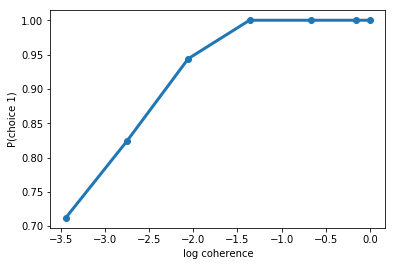

In [678]:
plt.plot(np.log(c), P_C1, '-o', lw=3)
plt.xlabel('log coherence')
plt.ylabel('P(choice 1)');

# (4) Reaction time
If we look at the reaction time, we also see that it decreases as we increase the coherence. This can be explained because there is less activation of the second population, thus less inhbition onto population 1 and quicker firing rate growth. 

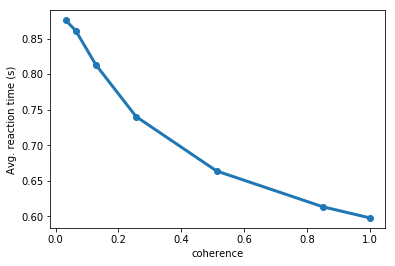

In [679]:
plt.plot(c, np.mean(RT, axis=1), '-o', lw=3)
plt.xlabel('coherence')
plt.ylabel('Avg. reaction time (s)');

# Weber's law
Increasing coherence not only decreases the average reaction time, but also the distribution of reaction times decreases. As shown below in the correlation between mean reation time and standard deviation. 

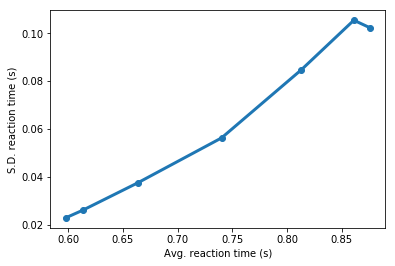

In [680]:
plt.plot(np.mean(RT, axis=1), np.std(RT, axis=1), '-o', lw=3)
plt.xlabel('Avg. reaction time (s)')
plt.ylabel('S.D. reaction time (s)');

# (5) Scale synaptic drive
If we tweek $\phi$ we can scale the synaptic input without changing the synaptic steady states. This results in a change of the time constant and again we see that as we increase the synaptic drive the reaction time is shorter. 

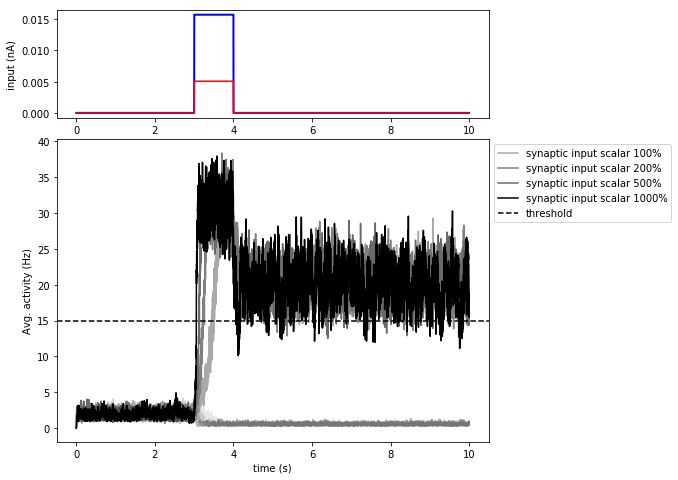

In [712]:
c = 0.512
mu = 20
I_1 = mu * (1 + c)
I_2 = mu * (1 - c)

phis = [1, 2, 5, 10]

RT = []
threshold = 15

fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0, 0, 1, .7])

cmap = ['darkgray', 'gray', 'dimgray', 'k']
for j in range(len(cmap)):
    plt.plot([], [], c=cmap[j])
plt.plot([], [], ls='--', c='k')
# cmap2 = ['lightcoral', 'red', 'firebrick', 'darkred']
cnt =0

for phi in phis:
    rt = []
    _, _, R1, R2, I1, I2, T = network.simulation(I_1=I_1, I_2=I_2, t=10, t1=3, t2=3, 
                                               pulse_t1=1., pulse_t2=1., phi=phi, n_trial=500, sigma=.01)
    
    RT1 = T[np.argmax(np.array(R1)>threshold, axis=0)]
    RT2 = T[np.argmax(np.array(R2)>threshold, axis=0)]
    
    for i in range(len(RT1)):
        a = RT1[i]
        b = RT2[i]
        if a == 0 and b ==0:
            print('change threshold or input parameters')
        elif a ==0 and b > 0:
            rt.append(b)
        elif b ==0 and a > 0:
            rt.append(a)
        elif b >0 and a > 0:
            if b > a:
                rt.append(a)
            else:
                rt.append(b)
    
    plt.plot(T, np.array(R1)[:, 0], c=cmap[cnt])
    plt.plot(T, np.array(R2)[:, 0], c=cmap[cnt], alpha=.3)
    cnt +=1
                
    RT.append(rt)

plt.axhline(y=threshold, color='k', linestyle='--')
plt.xlabel('time (s)')
plt.ylabel('Avg. activity (Hz)')    
plt.legend(['synaptic input scalar '+str(i*100)+'%' for i in phis]+['threshold'], bbox_to_anchor=(1, 1));  

ax = fig.add_axes([0, 0.75, 1, .25])
plt.plot(T, I1, 'blue', lw=2)
plt.plot(T, I2, 'red')
plt.ylabel('input (nA)')

RT = np.array(RT)

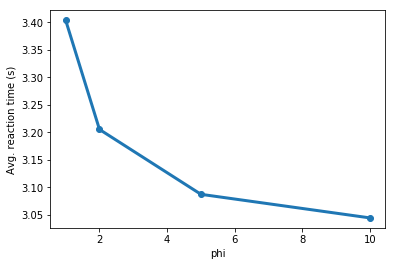

In [700]:
plt.plot(phis, np.mean(RT, axis=1), '-o', lw=3)
plt.xlabel('phi')
plt.ylabel('Avg. reaction time (s)');

# (6) Time of stimulation
This model predicts decision, but the outcome depends on the several parameters that we can feed to the model. For example if we provide a weak stimulus for a brief period of time the network fails to make a decision and imposing a threshold gives us random choices, but as we increase stimulus presentation duration the network is able to integrate information and reach a decision or state of high activity. 

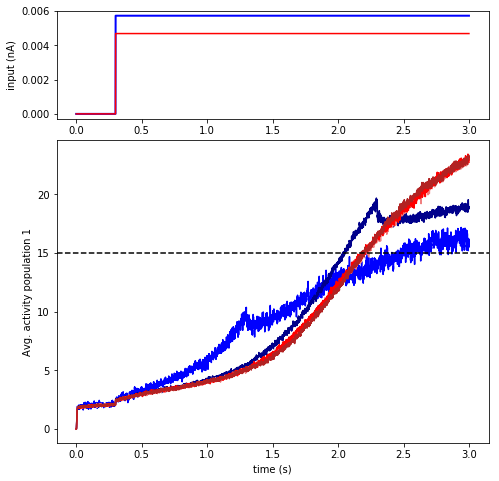

In [735]:
c = 0.1
t = [.1, .10001, .10002, .10003, .10005, .1001]
# I_1 = 40 * np.ones((len(c, )))
# I_2 = I_1* (1-c)/(1+c)
mu = 10
I_1 = mu * (1 + c)
I_2 = mu * (1 - c)

RT = []
P_C1 = []
threshold = 15

cmap = ['lightskyblue', 'blue', 'darkblue', 'lightcoral', 'red', 'firebrick', 'darkred']
cnt =0

fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0, 0, 1, .7])

for tt in range(len(t)):
    rt = []
    _, _, R1, R2, I1, I2, T = network.simulation(I_1=I_1, I_2=I_2, t=3, t1=.3, t2=.3, 
                                               pulse_t1=tt, pulse_t2=tt, n_trial=500)
    
    p_C1 = sum(np.array(R1)[-1, :] > np.array(R2)[-1, :]) / len(R1[0]) 
    
    RT1 = T[np.argmax(np.array(R1)>threshold, axis=0)]
    RT2 = T[np.argmax(np.array(R2)>threshold, axis=0)]
    P_C1.append(p_C1)
    
    mask = []
    
    for i in range(len(RT1)):
        a = RT1[i]
        b = RT2[i]
        if a == 0 and b ==0:
            rt.append(0)
#             print('change threshold or input parameters')
        elif a ==0 and b > 0:
            rt.append(b)
        elif b ==0 and a > 0:
            rt.append(a)
            mask.append(i)
        elif b >0 and a > 0:
            if b > a:
                rt.append(a)
                mask.append(i)
            else:
                rt.append(b)
    
    plt.plot(T, np.mean((np.array(R1)[:, mask]), axis=1), c=cmap[cnt])
#     plt.plot(T, np.mean(R1, axis=1), c=cmap[cnt])
    
    cnt +=1
                
    RT.append(rt)

plt.axhline(y=threshold, color='k', linestyle='--')
plt.xlabel('time (s)')
plt.ylabel('Avg. activity population 1')    
# plt.legend(['input coherence '+str(i*100)+'%' for i in c]+['threshold'], bbox_to_anchor=(1, 1));  

ax = fig.add_axes([0, 0.75, 1, .25])
plt.plot(T, I1, 'blue', lw=2)
plt.plot(T, I2, 'red')
plt.ylabel('input (nA)')

RT = np.array(RT)

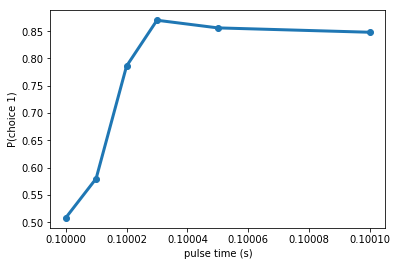

In [736]:
plt.plot(t, P_C1, '-o', lw=3)
plt.xlabel('pulse time (s)')
plt.ylabel('P(choice 1)');